# Проект 13. Компьютерное зрение.
# Определение возраста покупателей

## Описание проекта и постановка задачи.

В этом уроке проведите исследовательский анализ набора данных в Jupyter. Затем скачайте свою тетрадь Jupyter Notebook.

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/. В вашем распоряжении одна папка со всеми изображениями (/final_files) и csv-файл labels.csv с двумя колонками: file_name и real_age. Извлечь данные из папки вам поможет новый метод ImageDataGenerator —flow_from_dataframe(dataframe, directory, ...).

## Исследовательский анализ данных

Проведите исследовательский анализ данных:

    Посмотрите на размер выборки.
    Постройте график распределения возраста в выборке.
    Напечатайте на экране 10–15 фотографий и посмотрите, как устроен датасет.

Сделайте выводы о том, как результаты исследования повлияют на обучение модели.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#import warnings
import datetime

from IPython.display import display
#from scipy import stats as st

#from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression #, LinearRegression
from sklearn.tree import DecisionTreeClassifier #,DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
#from sklearn.ensemble import RandomForestRegressor #,RandomForestClassifier
#from sklearn.dummy import DummyRegressor#, DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import f1_score #, mean_squared_error, make_scorer, mean_absolute_error, r2_score, 
                                           #accuracy_score, f1_score, confusion_matrix, roc_auc_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image

In [2]:
#labels = pd.read_csv('https://code.s3.yandex.net/datasets/faces/labels.csv')
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
display(labels.sample(5))

,file_name,real_age
7201,007219.jpg,25
573,000573.jpg,32
3744,003744.jpg,46
6978,006989.jpg,70
6658,006663.jpg,52


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


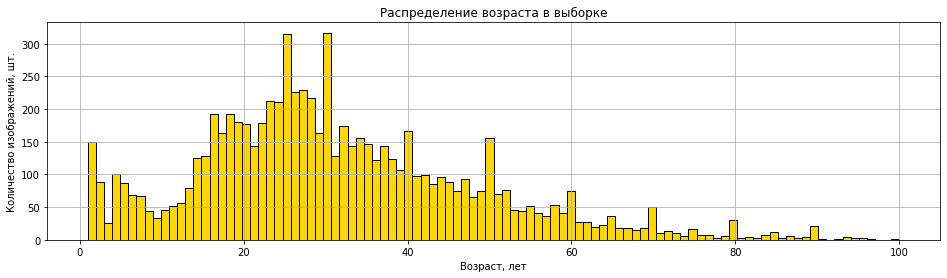

In [6]:
labels.hist(column='real_age', bins=100, figsize=(16, 4), color='gold', edgecolor = 'black')
plt.title("Распределение возраста в выборке")
plt.ylabel("Количество изображений, шт.")
plt.xlabel("Возраст, лет");

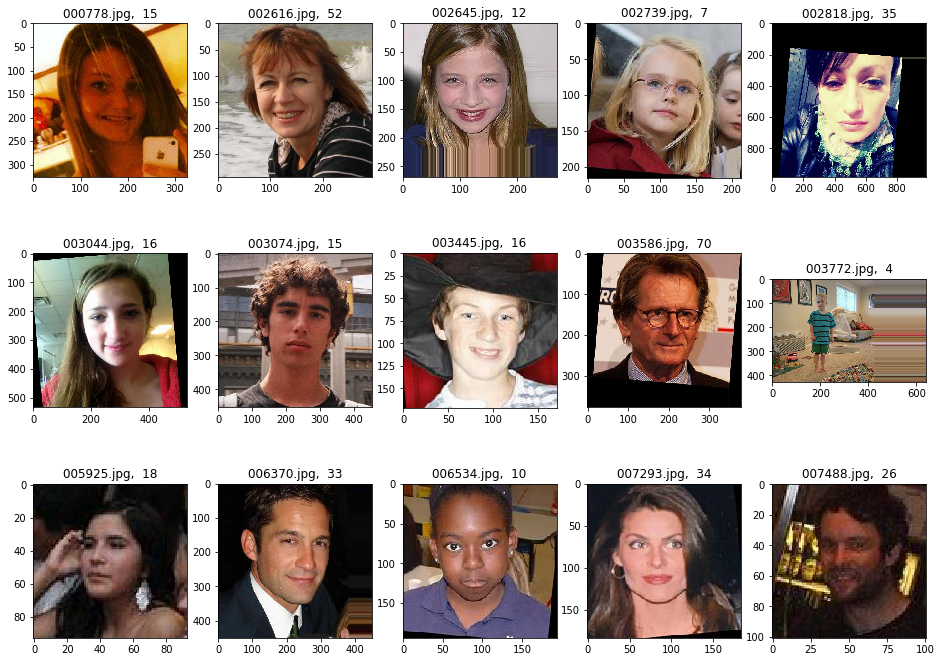

In [7]:
pictures = sorted(list(labels['file_name'].sample(15)))
pic_box = plt.figure(figsize=(16,12))

for i, name in enumerate(pictures):
    image = Image.open('/datasets/faces/final_files/'+name)
    age = labels.loc[labels.loc[:, 'file_name'] == str(name)]['real_age'].values[0]
    title = name + ',  ' + str(age)
    pic_box.add_subplot(3,5,i+1).set_title(title)
    plt.imshow(image)
plt.show()

Распределение по 'real_age' не равномерное. Мало данных для возрастов: 3, 8-12, 53-100. Изображения в папке неупорядочены. В большинстве случаев на фото 20-40% площади занимает лицо, но встречаются и фотографии в полный рост. Изображения ориентированы (лоб сверху, подбородок снизу). Среди цветных фотографий встречаются черно-белые, а также попадаются надписи поверх изображения. Вероятно модель неплохо обучится на возраст 16-35, но особенности набора изображений не дадут получить очень высокой точности.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

### Код

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, horizontal_flip=True)

def load_train(path):

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv('/datasets/faces/labels.csv'), #(path + 'labels.csv'),  
        directory='/datasets/faces/final_files/', #path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_datagen_flow


def load_test(path):
    
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv('/datasets/faces/labels.csv'), #(path + 'labels.csv'),  
        directory='/datasets/faces/final_files/', #path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_datagen_flow


def create_model(input_shape):
 
    optimizer = Adam(learning_rate=0.0005)

    backbone = ResNet50(input_shape=(150, 150, 3), weights='imagenet', include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
 
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer, 
                  metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=12,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

### Результат вывода модели

```
Found 5694 validated image filenames.

Found 1897 validated image filenames.

2021-06-08 22:49:00.834129: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1

2021-06-08 22:49:01.510832: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 

pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0

coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
```

```
Train for 178 steps, validate for 60 steps

Epoch 1/12

2021-06-09 07:54:39.105402: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2021-06-09 07:54:39.965685: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

178/178 - 150s - loss: 216.1359 - mae: 10.8594 - val_loss: 456.8679 - val_mae: 16.2907

Epoch 2/12

178/178 - 41s - loss: 114.1604 - mae: 8.1339 - val_loss: 447.8555 - val_mae: 16.0705

Epoch 3/12

178/178 - 40s - loss: 90.2046 - mae: 7.2567 - val_loss: 374.7837 - val_mae: 14.4457

Epoch 4/12

178/178 - 41s - loss: 72.8524 - mae: 6.5103 - val_loss: 231.3998 - val_mae: 11.4232

Epoch 5/12

178/178 - 40s - loss: 68.9258 - mae: 6.3245 - val_loss: 374.4761 - val_mae: 14.3343

Epoch 6/12

178/178 - 41s - loss: 52.9332 - mae: 5.5594 - val_loss: 87.0292 - val_mae: 7.1563

Epoch 7/12

178/178 - 40s - loss: 40.1046 - mae: 4.9009 - val_loss: 86.2360 - val_mae: 7.1190

Epoch 8/12

178/178 - 41s - loss: 33.1401 - mae: 4.3911 - val_loss: 79.7691 - val_mae: 6.8243

Epoch 9/12

178/178 - 41s - loss: 29.0792 - mae: 4.1341 - val_loss: 84.4908 - val_mae: 6.9294

Epoch 10/12

178/178 - 40s - loss: 23.3413 - mae: 3.7143 - val_loss: 81.4751 - val_mae: 6.7706

Epoch 11/12

178/178 - 40s - loss: 19.0671 - mae: 3.3464 - val_loss: 115.5217 - val_mae: 8.4905

Epoch 12/12

178/178 - 41s - loss: 17.1025 - mae: 3.1572 - val_loss: 78.4729 - val_mae: 6.6731


Задание выполнено верно

```

## Анализ обученной модели

Сеть ResNet50 + слой с активацией ReLu и оптимизатором Adam (со скоростью обучения learning_rate=0.0005) позволила получить среднюю ошибку в 6,67 лет (цель задачи достигута). Добавление в выборку данных с редкими значениями возраста, а также отфильтровывание некорректных изображений (плохо видно лицо, фотография в полный рост, надписи поверх изображений) позволит улучшить это значение.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы